In [1]:
%matplotlib inline

In [2]:
from pandas import *
from ggplot import *

In [3]:
turnstile_weather = pandas.read_csv('data/turnstile_data_master_with_weather.csv')

In [4]:
plot_df = turnstile_weather[['DATEn', 'ENTRIESn_hourly']]

In [5]:
plot_df.is_copy = False

In [6]:
plot_df['week_day'] = turnstile_weather['DATEn'].map(
            lambda x: datetime.strptime(x, '%Y-%m-%d').weekday())

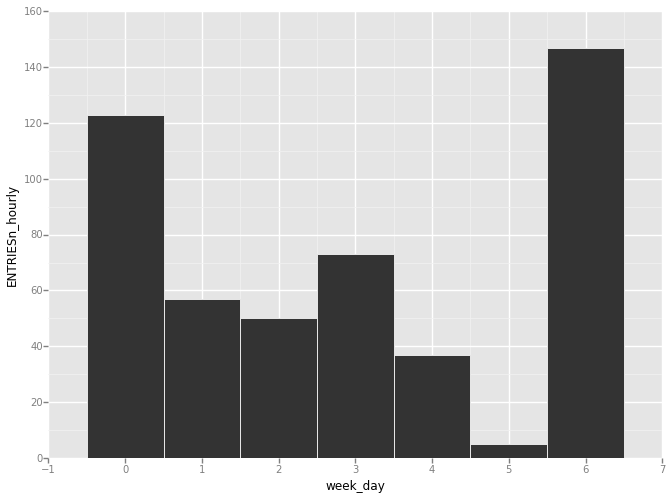

<ggplot: (283212969)>

In [7]:
ggplot(plot_df, aes('week_day', 'ENTRIESn_hourly')) + geom_bar(stat="bar")

The height of the bars is wrong. The number of entries is higher.  